## Lọc nhiễu ảnh
### 1. Lọc nhiễu Gauss
Sử dụng bộ lọc Gauss để giảm nhiễu, giúp tăng khả năng phát hiện cạnh bằng thuật toán Canny

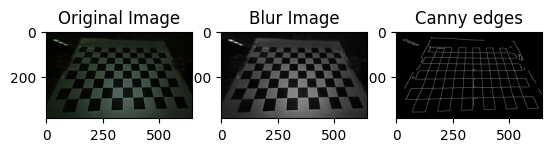

In [37]:
import cv2
from matplotlib import pyplot as plt

# Load the image
img1 = cv2.imread('Images/Chessboard_0481.png')
# Convert the image to grayscale
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

# Blur the image for better edge detection
img1_blur = cv2.GaussianBlur(gray1, (5, 5), 0)

# # Apply the Canny edge detector to find edges in the image
edges1 = cv2.Canny(img1_blur, 30, 55, apertureSize=3)

# Display the original and equalized images
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.subplot(1, 3, 2)
plt.imshow(img1_blur, cmap='gray')
plt.title('Blur Image')
plt.subplot(1, 3, 3)
plt.imshow(edges1,cmap='gray')
plt.title('Canny edges')
plt.show()

### 2. Lọc nhiễu muối tiêu
Sử dụng bộ lọc trung vị (Median filter) để lọc nhiễu muối tiêu, sau đó dùng bộ lọc Gauss để giảm nhiễu

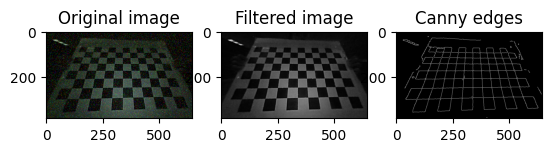

In [39]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

# Load the image
img2 = cv2.imread('Images/Chessboard_0481_0.png')
# Convert the image to grayscale
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# Apply median filter
ft_img2 = cv2.medianBlur(gray2, 3)
# Blur the image for better edge detection
img2_blur = cv2.GaussianBlur(ft_img2, (5, 5), 0)

# Apply the Canny edge detector to find edges in the image
edges2 = cv2.Canny(img2_blur, 30, 55, apertureSize=3)

# Show images
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.title('Original image')

plt.subplot(1, 3, 2)
plt.imshow(ft_img2, cmap='gray')
plt.title('Filtered image')

plt.subplot(1, 3, 3)
plt.imshow(edges2,cmap='gray')
plt.title('Canny edges')
plt.show()


### 3.Lọc nhiễu Sin

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

# Read the image and convert it to grayscale
image = cv2.imread('images/Chessboard_00451_2.png', 0)

# Compute the 2D Fourier transform of the image
fourier_transform = np.fft.fft2(image)

# Shift the zero-frequency component to the center of the spectrum
fourier_shift = np.fft.fftshift(fourier_transform)

# Create a mask with two lines
radius = 10
mask1 = np.ones_like(image)*255
mask2 = np.zeros_like(image)

center_y = mask1.shape[0] // 2
center_x = mask1.shape[1] // 2

cv2.line(mask2, (center_x+8,center_y),(center_x+8,center_y), (255,255,255), 1)[0]
cv2.line(mask2, (center_x-8,center_y),(center_x-8,center_y), (255,255,255), 1)[0]
mask = mask1 - mask2

# Apply the mask to the shifted Fourier transform
dft_shift_masked = np.multiply(fourier_shift,mask) / 255

# Shift the origin back to the upper left corner
back_ishift_masked = np.fft.ifftshift(dft_shift_masked)

# Compute the inverse Fourier transform to obtain the filtered image
img_filtered = np.fft.ifft2(back_ishift_masked)

# Clip and convert the image back to uint8 format
img_filtered = np.abs(img_filtered).clip(0,255).astype(np.uint8)

# Apply a Gaussian filter to smooth the image
blur = cv2.GaussianBlur(img_filtered,(11,11),0)
blur_img = cv2.cvtColor(blur, cv2.COLOR_BGR2RGB)

# Display the original and filtered images side by side
plt.subplot(1,2,1)
plt.imshow(image, cmap = 'gray')
plt.subplot(1,2,2)
plt.imshow(blur_img, cmap = 'gray')
plt.show()

## Thuật toán đếm số hàng và cột của bàn cờ

The chessboard has 9 rows and 12 columns


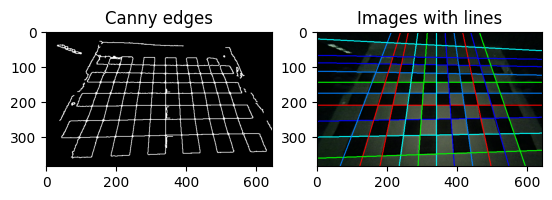

In [40]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

# Load the image
img = cv2.imread('Images/Chessboard_0481.png')
# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Blur the image for better edge detection
img_blur = cv2.GaussianBlur(gray, (5, 5), 0)

# Apply the Canny edge detector to find edges in the image
edges = cv2.Canny(img_blur, 30, 55, apertureSize=3)

# cv2.imshow("Test", edges)

kernel = np.ones((2, 2), np.uint8)
dilate = cv2.dilate(edges, kernel, iterations=2)  # < --- Added a dilate, check link I provided
ero = cv2.erode(dilate, kernel, iterations=1)

# Apply the Hough transform to find lines in the image
lines = cv2.HoughLines(ero, 1, np.pi / 180, 180)

filtered_lines = []
check = []
check_horizon = []
check_vertical = []

i = 0
for line in lines:
    exist = False
    rho, theta = line[0]
    rho_c = abs(int(rho))
    theta_c = int(theta / np.pi * 180)
    if 150 <= theta_c <= 210:
        theta_c = abs(theta_c - 180)
    if (30 < theta_c < 75) or (105 < theta_c < 150):
        i += 1
        exist = True
    if i == 0:
        check.append((theta_c, rho_c))
        if check[-1][0] > 45:
            check_horizon.append(check[-1])
        else:
            check_vertical.append(check[-1])
        filtered_lines.append(lines[i])
        i += 1
    else:
        for check_line in check:
            if abs(theta_c - check_line[0]) <= 3 and abs(rho_c - check_line[1]) <= 16:
                i += 1
                exist = True
                break
        if not exist:
            check.append((theta_c, rho_c))
            filtered_lines.append(lines[i])
            i += 1
            if check[-1][0] > 45:
                check_horizon.append(check[-1])
            else:
                check_vertical.append(check[-1])
            check_horizon = sorted(check_horizon, key=lambda last: last[-1])
            check_vertical = sorted(check_vertical, key=lambda last: last[-1])

    if i == len(lines):
        break

# Calculate the number of rows and columns on the chessboard
rows = len(check_horizon) - 1
cols = len(check_vertical) + 1

print(f'The chessboard has {rows} rows and {cols} columns')

# Draw lines on the image to show the grid of the chessboard

i = 0
rgb = [(0, 0, 255), (0, 127, 255), (0, 255, 255), (0, 255, 0), (255, 0, 0)]  # Red, Orange, Yellow, Green, Blue

for line in filtered_lines:
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 + 1000 * (-b))
    y1 = int(y0 + 1000 * a)
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * a)

    cv2.line(img, (x1, y1), (x2, y2), rgb[i], 2)

    theta_c = theta / np.pi * 180
    if 150 <= theta_c <= 210:
        theta_c = abs(theta_c - 180)

    i += 1
    if i == len(rgb):
        i = 0

# Display the image with lines drawn on it
plt.subplot(1, 2, 1)
plt.imshow(ero, cmap='gray')
plt.title('Canny edges')

plt.subplot(1, 2, 2)
plt.imshow(img, cmap='gray')
plt.title('Images with lines')
plt.show()
